<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA1: Deep Reinforcement Learning

#### AUTOR: Mario Ubierna San Mamés
 

En esta práctica se hará un estudio sobre el entorno **highway-env**, donde inicialmente se realizará una exploración sobre el entorno, posteriormente implementaremos un agente DQN y finalmente mejoraremos el primer agente implementado

## 0. Contexto

**Highway-env** es un problema de conducción autónoma, donde tenemos múltiples carriles y varios coches transitando. Nuestro objetivo es que el agente sea capaz de controlar el vehículo con el fin de:

- Evitar colisiones con otros vehículos.
- Tener la máxima velocidad posible.
- Mantenerse en el carril derecho lo más posible.

El entorno se considera superado cuando en el tiempo de observación máximo establecido, se han verificado las tres condiciones anteriores.

![Alt Text](https://raw.githubusercontent.com/eleurent/highway-env/gh-media/docs/media/highway-env.gif?raw=true)

## 1. Entorno

Lo primero de todo es cargar las librerías necesarias:

In [2]:
import gym
import highway_env
from collections import namedtuple, deque
from copy import deepcopy, copy
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import time

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.5 ptos) - </strong> Exploración del entorno y representación de una ejecución aleatoria:
</div>

#### Exploración del entorno

Carga del entorno:

In [3]:
# Definimos el entorno
env = gym.make("highway-v0")

Información básica del entorno:

In [4]:
print("El espacio de acciones es {} ".format(env.action_space))
print("La dimensión del espacio de acciones es: {}".format(env.action_space.n))
# print("Las acciones por defecto son {}".format(str(env.action_type.actions_indexes)))
print("El espacio de observaciones es {} ".format(env.observation_space))
print("La dimensión del espacio de estados: {}".format(env.observation_space.shape[0]))
print("El rango de recompensas es {} ".format(env.reward_range))

El espacio de acciones es Discrete(5) 
La dimensión del espacio de acciones es: 5
El espacio de observaciones es Box([[-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]], [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]], (5, 5), float32) 
La dimensión del espacio de estados: 5
El rango de recompensas es (-inf, inf) 


De la anterior ejecución podemos observar que, por defecto tanto la dimensión del espacio de acciones como de estados es 5. Estos valores vienen predefinidos a la hora de cargar el entorno **highway-v0**.  
  
Para saber más sobre la configuración por defecto del entorno ejecutamos la siguiente instrucción:

In [5]:
env.env.default_config()

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'offroad_terminal': False}

Como podemos ver obtenemos la siguiente información:  
- El tipo de observación es Kinematics, esto lo que significa es que el espacio de estados va a ser una matriz del tipo VxF, donde V es el número de vehículos cercanos a nuestro coche y F el número de características (['presence', 'x', 'y', 'vx', 'vy']).

- El tipo de acciones es DiscreteMetaAction, en este caso hay 5 acciones. La primera es movernos al carril de la izquierda "0", la segunda es un movimiento ilegal o mantenernos en el carril actual a la velocidad actual "1" (cuando se produce un cambio de carril en el límite de la carretera, o cuando la acelaración o desaceleración es mayor o menor que la velocidad máxima/mínima) "1", la tercera es movernos al carril de la derecha "2", la cuarta es aumentar la velocidad "3" y la quinta reducir la velocidad "4".

- El número de carriles es 4, se puede modificar para añadir más o menos.

- El número de vehículos es 50 y al igual que antes se puede modificar.

- La recompensa por colisión es -1.

- La recompensa por estar en el carril de la derecha es 0.1.

- La recompensa por alcanzar una alta velocidad es 0.4.

- La recompensa por cambiar de carril es 0.

- Y la recompensa por aumentar o disminuir la velocidad varía entre 20 y 30 dependiendo de forma lineal a su velocidad.

A continuación podemos ver un ejemplo de una acción tomada aleatoriamente y todas las posibles acciones que podemos tomar:

In [6]:
print("Acción aleatoria tomada {}".format(env.action_space.sample()))
print("Las posibles acciones son {}".format(env.action_type.actions_indexes))

Acción aleatoria tomada 2
Las posibles acciones son {'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}


Para concluir con la exploración del entorno, vamos a mostrar un ejemplo de un estado según el espacio de observaciones por defecto junto el nombre de cada columna:

In [7]:
print("Un estado aleatorio sería \n{}".format(env.observation_space.sample()))
print("El nombre de cada columna (característica \"F\") es {}".format(env.env.observation_type.features))

Un estado aleatorio sería 
[[ 0.47789434  0.14970075 -0.95439225 -0.5071257  -0.5717195 ]
 [-1.7145699  -1.08008     1.5356616   0.01742784 -0.14317273]
 [-0.4287193   1.2831037   0.85987455  0.6341575  -0.08645776]
 [ 0.72056687 -0.04689763 -0.17241746  0.10433157  0.9343766 ]
 [ 1.0721375  -0.36556318 -0.74792737 -1.3635495  -0.7361571 ]]
El nombre de cada columna (característica "F") es ['presence', 'x', 'y', 'vx', 'vy']


#### Representación de una ejecución aleatoria

Obs inicial:


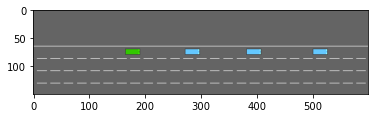

[[ 1.          0.91424745  0.          0.3125      0.        ]
 [ 1.          0.09642161  0.         -0.03039612  0.        ]
 [ 1.          0.19671127  0.         -0.02337849  0.        ]
 [ 1.          0.3051578   0.         -0.04828252  0.        ]
 [ 1.          0.41003048  0.25       -0.01353156  0.        ]]

Acción: LANE_RIGHT -> recommpensa: 0.8222222222222223
Nuevo estado:


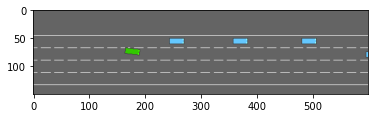

[[ 1.          1.          0.20821731  0.31063917  0.03405233]
 [ 1.          0.07142314 -0.20821731 -0.10351981 -0.03405233]
 [ 1.          0.17468563 -0.20821731 -0.09077308 -0.03405233]
 [ 1.          0.28658983 -0.20821731 -0.04845467 -0.03405233]
 [ 1.          0.39173892  0.05708825 -0.08667212 -0.03484139]]

Acción: SLOWER -> recommpensa: 0.7116739868390409
Nuevo estado:


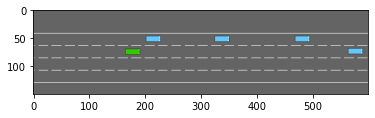

[[ 1.0000000e+00  1.0000000e+00  2.6070890e-01  2.6068038e-01
   2.6056790e-04]
 [ 1.0000000e+00  3.3068102e-02 -2.6070890e-01 -9.2326351e-02
  -2.6056790e-04]
 [ 1.0000000e+00  1.4542851e-01 -2.6070890e-01 -6.2157676e-02
  -2.6056790e-04]
 [ 1.0000000e+00  2.7588511e-01 -2.6070890e-01 -1.5201254e-02
  -2.6056790e-04]
 [ 1.0000000e+00  3.6226505e-01 -8.3880853e-03 -5.1026840e-02
  -2.2357439e-03]]

Acción: LANE_LEFT -> recommpensa: 0.0
Nuevo estado:


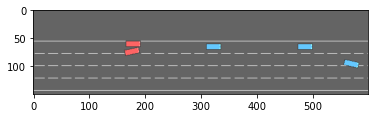

[[ 1.0000000e+00  1.0000000e+00  9.9087849e-02  1.5361723e-01
  -3.1473875e-02]
 [ 1.0000000e+00  7.9695828e-04 -1.5508990e-01 -5.4045837e-02
   3.1473875e-02]
 [ 1.0000000e+00  1.3150257e-01 -9.9087849e-02  4.0373322e-02
   3.1473875e-02]
 [ 1.0000000e+00  2.8039789e-01 -9.9087849e-02  8.5128158e-02
   3.1473875e-02]
 [ 1.0000000e+00  3.5626110e-01  2.5441664e-01  6.6620506e-02
   8.0655940e-02]]
Episodio terminado después de 3 pasos y la recompensa fue 1.5338962090612633


In [11]:
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = env.action_space.sample()
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2 (0.5 ptos) - </strong> Explicar los diferentes espacios de observaciones y de acciones:
</div>

Resuelto en el informe

## 2. Agente de referencia

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.1 (1.5 ptos) - </strong> Implementar un agente DQN con la observación kinematics
</div>

Lo primero de todo es definir la clase que nos va a permitir crear el replay buffer:

In [12]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

Posteriormente tenemos que crear la red neuronal:

In [36]:
class NeuralNet(torch.nn.Module):  

    def __init__(self, env, learning_rate=1e-3):
        
        """
        Params
        ======
        n_inputs: tamaño del espacio de estadps
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        ######################################
        ##TODO: Inicializar parámetros
        super(NeuralNet, self).__init__()
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        #######################################
        ##TODO: Neural network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_outputs, bias=True),
        )
        
        #######################################
        ##TODO: Initialize optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)


    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción random
        else:
            qvals = self.get_qvals(state)  # acción del cálculo de Q para esta acción
#             print(state)
#             print(qvals)
#             print(state[0])
#             print(self.get_qvals(state[0]))
#             action= torch.max(qvals, dim=-1)[1].item()
            action= torch.max(qvals[0], dim=-1)[1].item()
#             print(action)
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
#             print("*******************")
#             print("ACTUALIZCION")
#             print(state)
#             state = np.array([np.ravel(s) for s in state])
#             print(state)
#             print("*******************")
            lista = []
            for s in state:
                lista.append(s[0])
            state = np.array(lista)
        state_t = torch.FloatTensor(state)
        return self.model(state_t)  

Luego tenemos que crear el agente:

In [37]:
class DQNAgent:
    
    ######################################
    ##TODO 1: Declarar variables
    def __init__(self, env, main_network, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) 
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 # bloque de los X últimos episodios de los que se calculará la media de recompensas
        self.initialize()
        
    ######################################
    ##TODO 2: Inicializar otras variables necesarias
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.history_loss = []
        self.update_epsilon = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()
    
    ######################################
    ##TODO 3: Tomar paso siguiente
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.main_network.get_action(self.state0, eps) # acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1
            
        #TODO: tomar 'step' i obtener nuevo estado y recompensa. Guardar la experiencia en el buffer
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state)
        self.state0 = new_state.copy()
        
        #TODO: resetear entorno 'if done'
        if done:
            self.state0 = self.env.reset()
        return done

    ## TRAINING
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

            
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')
                
                #################################################################################
                #####TODO 4:  Actualizar la red principal según la frecuencia establecida #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                    
                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict()
                    )
                    self.sync_eps.append(episode)
                
                if gamedone:                   
                    episode += 1
                    
                    # Guardamos la evolución de la pérdida
                    self.history_loss.append(np.mean(self.update_loss))
                        
                    self.update_loss = []
                                    
                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar
                    self.training_rewards.append(self.total_reward)
                    mean_rewards = np.mean(
                        self.training_rewards[-self.nblock:]
                    )
                    self.mean_training_rewards.append(mean_rewards)

                    self.update_epsilon.append(self.epsilon) # Guardamos la evolución de epsilon
                    
                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")
                    
                    #######################################################################################
                    ### TODO 8: Comprobar que todavía quedan episodios. Parar el aprendizaje si se llega al límite
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached')
                        break
                    
                    #Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego  
#                     if mean_rewards >= self.reward_threshold:
#                         training = False
#                         print('\nEnvironment solved in {} episodes!'.format(
#                             episode))
#                         break
                    
                    #################################################################################
                    ######TODO 9: Actualizar epsilon según la velocidad de decaimiento fijada########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)

                    
    #####################################         
    #####TODO 5: cálculo de la pérdida###
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores 
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1)
        dones_t = torch.ByteTensor(dones)
        
#         print(states)
#         print("*******************")
#         print(actions)
#         print("*******************")
#         print(actions_vals)
#         print("*******************")
#         aux1 = self.main_network.get_qvals(states) 
#         print(aux1)
        
        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
#         print(qvals)
        # Obtenemos los valores de Q objetivo. El parámetro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        
        #################################################################################
        ### TODO: Calcular ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        #################################################################################
        ### TODO: Calcular la pérdida (MSE)
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        
        return loss

    
    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().numpy())
        
    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.title("Evolución de las recompensas")
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc="upper left")
        plt.show()
        
    def plot_loss(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.history_loss)
        plt.title("Evolución de la pérdida")
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.show()
        
    def plot_epsilon(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.update_epsilon)
        plt.title("Evolución de epsilon")
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.show()

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.2 (1 ptos) - </strong> Entrenar el agente y buscar los hiperparámetros óptimos:
</div>

In [41]:
# Definición de los hiperparámetros
lr = 0.001            # Velocidad de aprendizaje
BATCH_SIZE = 32       # Tamaño del batch
MAX_EPISODES = 1500   # Número de episodios
BURN_IN = 100        # Número de episodios para rellenar el buffer
DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
MEMORY_SIZE = 10000   # Capacidad máxima del buffer
GAMMA = 0.99          # Factor de descuento
EPSILON = 1           # Epsilon
EPSILON_DECAY = 0.99   # Decaimiento de epsilon
# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 5000   # Número de episodios
# BURN_IN = 1        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10   # Capacidad máxima del buffer
# GAMMA = 0.99          # Factor de descuento
# EPSILON = 0.01           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon

In [ ]:
# Carga de la red neuronal
dqn = NeuralNet(env, learning_rate=lr)

# Creación del buffer
buffer = experienceReplayBuffer(
    memory_size=MEMORY_SIZE, 
    burn_in=BURN_IN
)

# Creación del agente
agent_dqn = DQNAgent(
    env=env,
    main_network=dqn,
    buffer=buffer,
    epsilon=EPSILON,
    eps_decay=EPSILON_DECAY,
    batch_size=BATCH_SIZE
)

# Entrenamos el agente
agent_dqn.train(
    gamma=GAMMA, 
    max_episodes=MAX_EPISODES, 
    batch_size=BATCH_SIZE,  
    dnn_update_frequency=DNN_UPD, 
    dnn_sync_frequency=DNN_SYNC
)

Filling replay buffer...
Training...


<ipython-input-37-018314396d97>:152: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  qvals_next[dones_t] = 0 # 0 en estados terminales


Episode 74 Mean Rewards 7.99 Epsilon 0.4801414565714212			

In [27]:
# Guardamos el modelo entrenado
trained_model = {
    "state_dic" : agent_dqn.main_network.state_dict()
}
torch.save(trained_model, "DQN.pth")

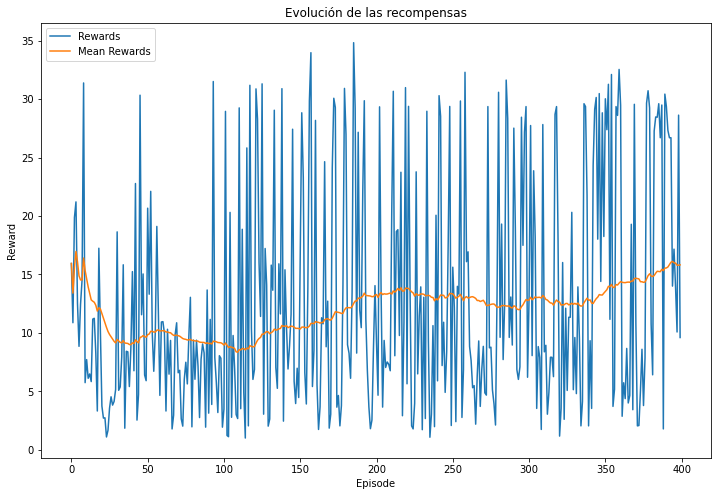

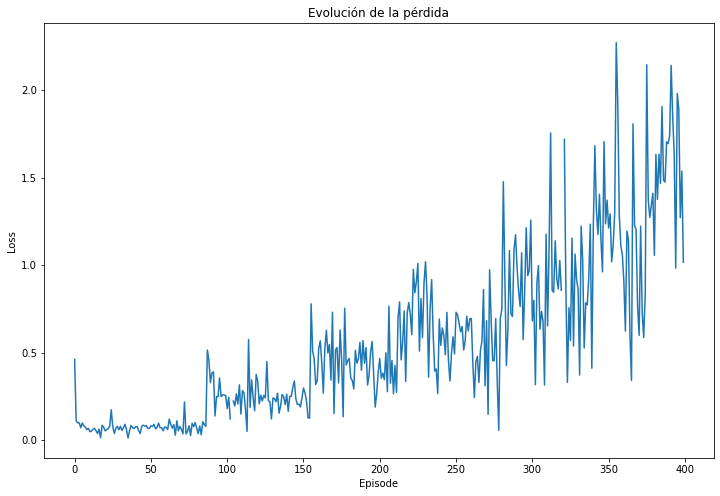

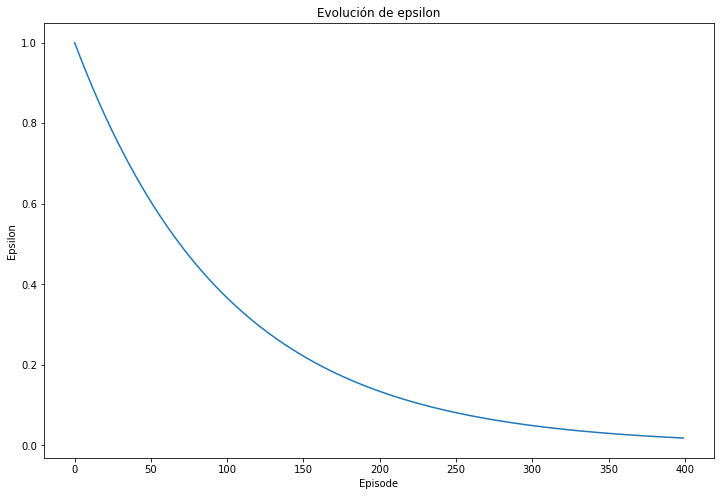

In [28]:
agent_dqn.plot_rewards()
agent_dqn.plot_loss()
agent_dqn.plot_epsilon()

Obs inicial:


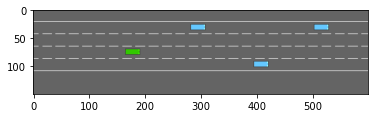

[[ 1.          0.8841239   0.5         0.3125      0.        ]
 [ 1.          0.10604618 -0.5        -0.03146555  0.        ]
 [ 1.          0.2090607   0.25       -0.01598159  0.        ]
 [ 1.          0.30703878 -0.5        -0.04495231  0.        ]
 [ 1.          0.40225348  0.         -0.02984752  0.        ]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


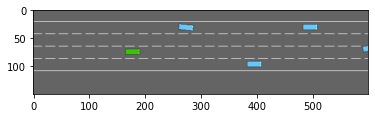

[[ 1.          1.          0.5         0.3125      0.        ]
 [ 1.          0.08646601 -0.47929984 -0.06348836  0.02552136]
 [ 1.          0.19756866  0.25       -0.04226398  0.        ]
 [ 1.          0.2886482  -0.5        -0.04694369  0.        ]
 [ 1.          0.38683558 -0.06424861 -0.05001203 -0.04471232]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


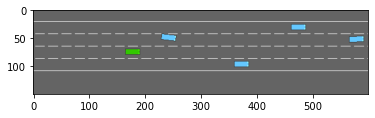

[[ 1.          1.          0.5         0.3125      0.        ]
 [ 1.          0.05828451 -0.27540773 -0.06914412  0.02692914]
 [ 1.          0.17701696  0.25       -0.06035275  0.        ]
 [ 1.          0.2696312  -0.5        -0.04815133  0.        ]
 [ 1.          0.36475202 -0.24237938 -0.05920607 -0.01789958]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


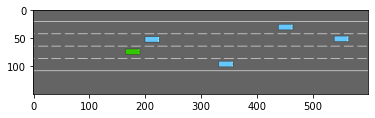

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  3.1542208e-02 -2.3956668e-01 -6.5708786e-02
  -5.3866522e-04]
 [ 1.0000000e+00  1.5107507e-01  2.5000000e-01 -6.3115939e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.4860835e-01 -5.0000000e-01 -5.7711195e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.3996129e-01 -2.5844887e-01 -6.1388452e-02
   1.6320880e-03]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


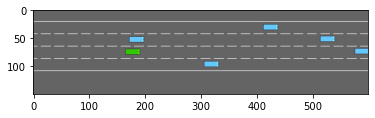

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  5.5803438e-03 -2.4854009e-01 -6.3957058e-02
  -1.3126321e-03]
 [ 1.0000000e+00  1.2778501e-01  2.5000000e-01 -5.3316262e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.2452785e-01 -5.0000000e-01 -6.2298276e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.1666139e-01 -2.5049126e-01 -5.5260871e-02
   8.8890141e-04]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


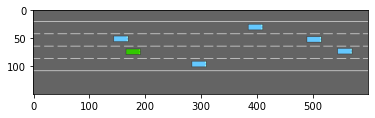

[[ 1.00000000e+00  1.00000000e+00  5.00000000e-01  3.12500000e-01
   0.00000000e+00]
 [ 1.00000000e+00 -1.96795557e-02 -2.50476032e-01 -6.22654967e-02
  -1.49897494e-06]
 [ 1.00000000e+00  1.07765384e-01  2.50000000e-01 -4.68072593e-02
   0.00000000e+00]
 [ 1.00000000e+00  1.99232206e-01 -5.00000000e-01 -6.39768913e-02
   0.00000000e+00]
 [ 1.00000000e+00  2.95263708e-01 -2.49581918e-01 -5.18498793e-02
  -6.91767564e-05]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


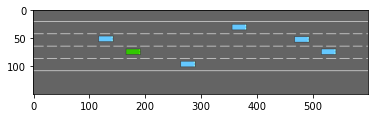

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00 -4.4308204e-02 -2.5008097e-01 -6.0828838e-02
   6.3786363e-05]
 [ 1.0000000e+00  8.9888312e-02  2.5000000e-01 -4.2611841e-02
   0.0000000e+00]
 [ 1.0000000e+00  1.7354794e-01 -5.0000000e-01 -6.4324595e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.7489448e-01 -2.4996871e-01 -5.0084054e-02
  -4.5517558e-05]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


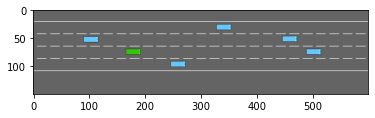

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  7.3378541e-02  2.5000000e-01 -3.9966669e-02
   0.0000000e+00]
 [ 1.0000000e+00  1.4785093e-01 -5.0000000e-01 -6.4084120e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.5503561e-01 -2.5002047e-01 -4.9273945e-02
   2.7877381e-06]
 [ 1.0000000e+00  2.9403850e-01  4.6791578e-05 -6.0754064e-02
  -5.1706775e-05]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


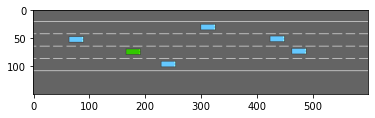

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  5.7724070e-02  2.5000000e-01 -3.8328700e-02
   0.0000000e+00]
 [ 1.0000000e+00  1.2230151e-01 -5.0000000e-01 -6.3610189e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.3538922e-01 -2.5000188e-01 -4.9006332e-02
   2.3190130e-06]
 [ 1.0000000e+00  2.7000022e-01 -2.0740481e-05 -5.9477862e-02
   1.4397694e-06]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


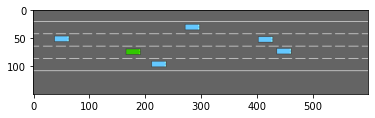

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  4.2595174e-02  2.5000000e-01 -3.7333194e-02
   0.0000000e+00]
 [ 1.0000000e+00  9.6958108e-02 -5.0000000e-01 -6.3066877e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.1578740e-01 -2.4999900e-01 -4.9041815e-02
  -1.0367750e-07]
 [ 1.0000000e+00  2.4635433e-01 -2.7021026e-06 -5.8773033e-02
   2.5557717e-06]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


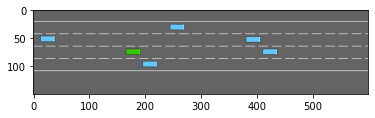

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.7782500e-02  2.5000000e-01 -3.6743712e-02
   0.0000000e+00]
 [ 1.0000000e+00  7.1833126e-02 -5.0000000e-01 -6.2525347e-02
   0.0000000e+00]
 [ 1.0000000e+00  1.9613689e-01 -2.4999990e-01 -4.9244113e-02
  -1.1741270e-07]
 [ 1.0000000e+00  2.2292621e-01  9.6188910e-07 -5.8378235e-02
  -2.0783261e-08]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


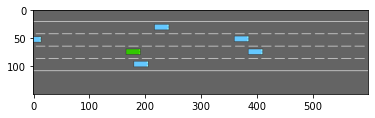

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.3153922e-02  2.5000000e-01 -3.6410313e-02
   0.0000000e+00]
 [ 1.0000000e+00  4.6919826e-02 -5.0000000e-01 -6.2012758e-02
   0.0000000e+00]
 [ 1.0000000e+00  1.7638685e-01 -2.5000006e-01 -4.9536079e-02
   3.3185434e-09]
 [ 1.0000000e+00  1.9962139e-01  1.5103552e-07 -5.8150601e-02
  -1.2538800e-07]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


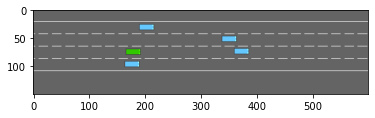

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00 -1.3740096e-03  2.5000000e-01 -3.6239188e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.2204842e-02 -5.0000000e-01 -6.1536528e-02
   0.0000000e+00]
 [ 1.0000000e+00  1.5651038e-01 -2.5000000e-01 -4.9873885e-02
   5.9051515e-09]
 [ 1.0000000e+00  1.7638896e-01 -4.4108184e-08 -5.8013145e-02
  -1.4224385e-09]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


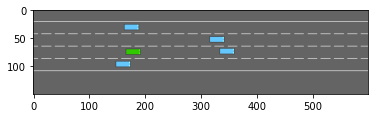

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00 -2.3263937e-03 -5.0000000e-01 -6.1095931e-02
   0.0000000e+00]
 [ 1.0000000e+00 -1.5854418e-02  2.5000000e-01 -3.6172159e-02
   0.0000000e+00]
 [ 1.0000000e+00  1.3649431e-01 -2.5000000e-01 -5.0232369e-02
  -6.9884543e-11]
 [ 1.0000000e+00  1.5320140e-01 -8.2483789e-09 -5.7924636e-02
   6.1052736e-09]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


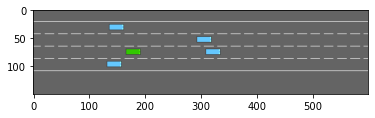

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00 -2.6687512e-02 -5.0000000e-01 -6.0687408e-02
   0.0000000e+00]
 [ 1.0000000e+00 -3.0321673e-02  2.5000000e-01 -3.6173351e-02
   0.0000000e+00]
 [ 1.0000000e+00  1.1633336e-01 -2.5000000e-01 -5.0596830e-02
  -2.9494474e-10]
 [ 1.0000000e+00  1.3004370e-01  1.9972970e-09 -5.7862990e-02
   1.8827295e-10]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


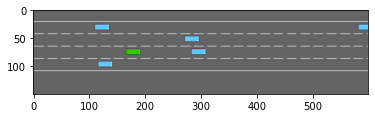

[[ 1.00000000e+00  1.00000000e+00  5.00000000e-01  3.12500000e-01
   0.00000000e+00]
 [ 1.00000000e+00 -4.47985902e-02  2.50000000e-01 -3.62207405e-02
   0.00000000e+00]
 [ 1.00000000e+00  9.60269198e-02 -2.50000000e-01 -5.09584695e-02
  -1.38733469e-12]
 [ 1.00000000e+00  1.06907584e-01  4.42379022e-10 -5.78163043e-02
  -2.95008129e-10]
 [ 1.00000000e+00  3.79089862e-01 -5.00000000e-01 -4.69125174e-02
  -3.97314182e-10]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


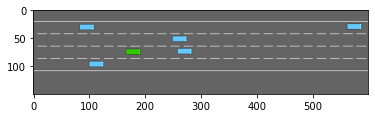

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  7.5577222e-02 -2.5000000e-01 -5.1311877e-02
   1.4626966e-11]
 [ 1.0000000e+00  8.3788410e-02 -8.9126040e-11 -5.7778079e-02
  -1.4939827e-11]
 [ 1.0000000e+00  3.6034214e-01 -5.0000000e-01 -4.6821799e-02
   4.8205884e-13]
 [ 1.0000000e+00  4.0080318e-01  2.5000000e-01 -3.8557649e-02
   0.0000000e+00]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


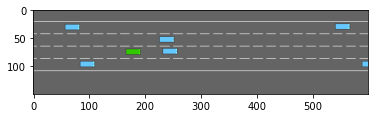

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  5.4988246e-02 -2.5000000e-01 -5.1653646e-02
   3.1441516e-13]
 [ 1.0000000e+00  6.0683530e-02 -2.3375524e-11 -5.7744678e-02
   1.4143797e-11]
 [ 1.0000000e+00  3.4162900e-01 -5.0000000e-01 -4.6739444e-02
   1.9956259e-11]
 [ 1.0000000e+00  3.8529766e-01  2.5000000e-01 -3.9000914e-02
   0.0000000e+00]]

Acción: IDLE -> recommpensa: 0.8444444444444444
Nuevo estado:


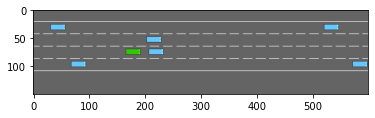

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  3.4265090e-02 -2.5000000e-01 -5.1981572e-02
  -7.2009065e-13]
 [ 1.0000000e+00  3.7591454e-02  3.9075410e-12 -5.7714000e-02
   1.0054180e-12]
 [ 1.0000000e+00  3.2294780e-01 -5.0000000e-01 -4.6662074e-02
   2.6512126e-13]
 [ 1.0000000e+00  3.6961320e-01  2.5000000e-01 -3.9452981e-02
   0.0000000e+00]]

Acción: IDLE -> recommpensa: 0.04444444444444443
Nuevo estado:


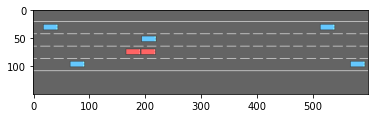

[[ 1.0000000e+00  1.0000000e+00  5.0000000e-01  2.0657164e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.5000000e-02  1.4188650e-12 -3.8138974e-02
  -4.9116267e-13]
 [ 1.0000000e+00  2.5582712e-02 -2.5000000e-01  5.3634141e-02
  -2.7866598e-14]
 [ 1.0000000e+00  3.1646603e-01 -5.0000000e-01  5.9340548e-02
  -9.9853459e-13]
 [ 1.0000000e+00  3.6591542e-01  2.5000000e-01  6.6014521e-02
   0.0000000e+00]]
Episodio terminado después de 19 pasos y la recompensa fue 15.244444444444447


In [40]:
# Carga del modelo entrenado
modelo = torch.load("DQN.pth")['state_dic']
dqn.load_state_dict(modelo)

obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = dqn.get_action(obs, 0)
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))